### Code for Optimizing FATES Allometric Function

In this notebook I will:
1. Bring in and subset the baad (Biomass And Allometry Dataset) for ponderosa pine height, diameter at breast height (dbh), and ...
2. Define allometric functions for dbh to height (d2h), dbh to above ground biomass (d2bagw), and dbh to leaf biomass (d2blmax). Functions come from FATES technical documentation https://fates-docs.readthedocs.io/en/latest/fates_tech_note.html#allometry-and-growth-along-allometric-curves.
3. Use curve fitting and other optimization techniques to determine the parameters for ponderosa pine for use in future FATES runs.

### Date_init:l 20 Sept 2019, copied from baad_data_test
### Copied: 26 Sept 2019
### Author: Katie Murenbeeld
### Updated: 26 Mar 2020 (renamed from FATES_Param_Opt-Copy1 to FATES_Param_Allometry)
### Updated: 7 Sept 2020 - added figures or plots with allom param values generated using Chonnang's scripts.

### Updated: 15 Mar 2021 - added in ponderosa pine data from BBEF

### 1) Bring in and subset observational datasets:
Here I will load necessary python libraries, set my data and data output directories, load the observational dataset(s), subset for ponderose pine and desired variables (height, dbh,...), and perform some basic statistics.

In [1]:
# Load appropriate libraries
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# Set the directories
baad_dir = '/Users/kathrynmurenbeeld/Desktop/CLM/FATES/baad_downloads/baad_data/'
baad_dir_out = '/Users/kathrynmurenbeeld/Desktop/CLM/FATES/baad_downloads/baad_data_out/'
bbef_dir = '/Users/kathrynmurenbeeld/Desktop/BBEF/DATA/'
bbef_dir_out = '/Users/kathrynmurenbeeld/Desktop/BBEF/DATA/'

In [3]:
# Read in the data, Do not have to do once a new subset .csv has been created
# df = pd.read_csv(data_dir + 'baad_data_2.csv').reset_index() 
# df.head(1)


In [4]:
# Sort out the ponderosa pine data, do not have to do once a new subset .csv has been created
#pipo = df.loc[df['species']=='Pinus ponderosa'].copy().reset_index()
# Save the dataframe as a csv
#pipo.to_csv(data_dir_out + "baad_pipo.csv", sep=',', encoding='utf-8')
#pipo.head(5)

# Read in the subset data
pipo = pd.read_csv(baad_dir_out + 'baad_pipo.csv')
pipo.head(5)

,Unnamed: 0,level_0,index,studyName,location,latitude,longitude,vegetation,map,mat,...,r.st,r.ss,r.sb,r.sh,n.lf,n.ss,n.sb,n.sh,n.rf,n.rc
0,0,3428,3428,Brown1978,northern Rocky Mountains U.S.A.,47.44,-115.7,TempF,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3455,3455,Brown1978,northern Rocky Mountains U.S.A.,47.44,-115.7,TempF,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3464,3464,Brown1978,northern Rocky Mountains U.S.A.,47.44,-115.7,TempF,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3470,3470,Brown1978,northern Rocky Mountains U.S.A.,47.44,-115.7,TempF,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3477,3477,Brown1978,northern Rocky Mountains U.S.A.,47.44,-115.7,TempF,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Read in a review the BBEF data

bbef = pd.read_csv(bbef_dir + 'BBEF-PP-DBH-H-data_copy.csv')
bbef.head(5)

,BBEF_Study-name,Year,Plot_ID,Tree_ID,Species,DBH-in,Height-ft,DBH-cm,H-m
0,Amber Fuels,2013,451,1,PP,31.6,127.0,80.3,38.7
1,Amber Fuels,2013,451,2,PP,20.7,102.0,52.6,31.1
2,Amber Fuels,2013,452,1,PP,19.0,79.0,48.3,24.1
3,Amber Fuels,2013,452,2,PP,16.9,76.0,42.9,23.2
4,Amber Fuels,2013,452,3,PP,44.9,115.0,114.0,35.1


In [6]:
bbef['DBH-m'] = bbef['DBH-cm']/100
bbef.head(5)

,BBEF_Study-name,Year,Plot_ID,Tree_ID,Species,DBH-in,Height-ft,DBH-cm,H-m,DBH-m
0,Amber Fuels,2013,451,1,PP,31.6,127.0,80.3,38.7,0.803
1,Amber Fuels,2013,451,2,PP,20.7,102.0,52.6,31.1,0.526
2,Amber Fuels,2013,452,1,PP,19.0,79.0,48.3,24.1,0.483
3,Amber Fuels,2013,452,2,PP,16.9,76.0,42.9,23.2,0.429
4,Amber Fuels,2013,452,3,PP,44.9,115.0,114.0,35.1,1.140


In [7]:
# Review the max height by location
max_h = pipo.groupby('location')['h.t'].max().reset_index()
max_h

,location,h.t
0,Priest River Experimental Forest,41.160003
1,Pringle Butte and Lookout Mountain,13.700000
2,"central Oregon, USA",20.150000
3,"eastern side of the Oregon Cascade Range, USA ...",35.750000
4,northern Rocky Mountains U.S.A.,44.013120
5,"western Montana, USA",22.070000


In [8]:
# Review the min height by location
min_h = pipo.groupby('location')['h.t'].min().reset_index()
min_h

,location,h.t
0,Priest River Experimental Forest,3.57000
1,Pringle Butte and Lookout Mountain,2.11000
2,"central Oregon, USA",1.66000
3,"eastern side of the Oregon Cascade Range, USA ...",2.99614
4,northern Rocky Mountains U.S.A.,0.70104
5,"western Montana, USA",1.75000


In [9]:
# Review the mean height by location
mean_h = pipo.groupby('location')['h.t'].mean().reset_index()
mean_h

,location,h.t
0,Priest River Experimental Forest,25.640909
1,Pringle Butte and Lookout Mountain,9.044694
2,"central Oregon, USA",7.442581
3,"eastern side of the Oregon Cascade Range, USA ...",18.044303
4,northern Rocky Mountains U.S.A.,11.788987
5,"western Montana, USA",8.865385


In [10]:
# Review basic stats on height
pipo['h.t'].describe()

count    272.000000
mean      11.368276
std        9.679318
min        0.598000
25%        3.687500
50%        8.627920
75%       14.212500
max       44.013120
Name: h.t, dtype: float64

In [11]:
# Review basic stats on dbh
pipo['d.bh'].describe()

count    263.000000
mean       0.202426
std        0.184924
min        0.007620
25%        0.077100
50%        0.147320
75%        0.248910
max        0.863600
Name: d.bh, dtype: float64

In [12]:
# Review basic stats, height where dbh measurements taken
pipo['h.bh'].describe()

count    268.000000
mean       1.355336
std        0.045775
min        1.300000
25%        1.300000
50%        1.370000
75%        1.400000
max        1.400000
Name: h.bh, dtype: float64

In [13]:
# Create data frames and show stats for height at specified dbh by showing only data collected for specific dbh.
# Here for a dbh of 10cm I took the measurements from 5-15cm to represent 10cm dbh. 
# Repeat the process up to 90cm.

mask10 = (pipo['d.bh'] >= 0.05) & (pipo['d.bh'] < 0.15)
pipo_10 = pipo.loc[mask10].copy()
pipo_10_stats = pd.DataFrame(pipo_10['h.t'].describe())
pipo_10_stats = pipo_10_stats.rename(columns={"h.t": "10"})
pipo_10_stats

,10
count,87.000000
mean,6.235619
std,2.370563
min,2.700000
25%,4.236720
50%,5.849999
75%,8.010000
max,14.130000


In [14]:
# Set dbh_mod to the ranges of dbh needed for calculation. In this case I want an array from 10-90 in steps of 10.
dbh_mod = [10,20,30,40,50,60,70,80,90]
dbh_mod

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [15]:
#pipo_stats = pd.DataFrame({'10': [], '20': [], '30': [], '40': [], '50': [], '60': [], '70': [], '80': [], '90': []})
# Just do for mean or can do separately for mean, min, and max
baad_mean_h = []

for i in dbh_mod:
    mask =  (pipo['d.bh']>= ((i/100) - 0.05)) & (pipo['d.bh']<((i/100) + 0.05))
    pipo_ = pipo.loc[mask].copy()
    stats = pipo_['h.t'].mean()
    print(stats)
    
   
    #result.append(float(lat))
    #stats_ = pd.DataFrame[stats]
    baad_mean_h.append(stats)
    #pipo_stats = pipo_stats.append({'10': [stats], 
     #                               '20': [], 
     #                               '30': [], 
     #                               '40': [], 
     #                               '50': [], 
     #                               '60': [], 
     #                               '70': [], 
     #                               '80': [], 
     #                               '90': []}, 
     #                                ignore_index=True)
print(baad_mean_h)

6.235619306689652
12.49633603307692
16.81861929851852
25.094844526666666
29.02481169714286
31.67804962
32.92736844222222
34.49056
44.01312
[6.235619306689652, 12.49633603307692, 16.81861929851852, 25.094844526666666, 29.02481169714286, 31.67804962, 32.92736844222222, 34.49056, 44.01312]


In [16]:
baad_mean_h

[6.235619306689652,
 12.49633603307692,
 16.81861929851852,
 25.094844526666666,
 29.02481169714286,
 31.67804962,
 32.92736844222222,
 34.49056,
 44.01312]

^^ You can work on that for loop later. Get back to the actual functions. Could probably just print out the means ^^

In [17]:
mask20 = (pipo['d.bh'] >= 0.15) & (pipo['d.bh'] < 0.25)
pipo_20 = pipo.loc[mask20].copy()
#pipo_20['h.t'].describe()

In [18]:
mask30 = (pipo['d.bh'] >= 0.25) & (pipo['d.bh'] < 0.35)
pipo_30 = pipo.loc[mask30].copy()
#pipo_30['h.t'].describe()

In [19]:
mask40 = (pipo['d.bh'] >= 0.35) & (pipo['d.bh'] < 0.45)
pipo_40 = pipo.loc[mask40].copy()
#pipo_40['h.t'].describe()

In [20]:
mask50 = (pipo['d.bh'] >= 0.45) & (pipo['d.bh'] < 0.55)
pipo_50 = pipo.loc[mask50].copy()
#pipo_50['h.t'].describe()

In [21]:
mask60 = (pipo['d.bh'] >= 0.55) & (pipo['d.bh'] < 0.65)
pipo_60 = pipo.loc[mask60].copy()
#pipo_60['h.t'].describe()

In [22]:
mask70 = (pipo['d.bh'] >= 0.65) & (pipo['d.bh'] < 0.75)
pipo_70 = pipo.loc[mask70].copy()
#pipo_70['h.t'].describe()

In [23]:
mask80 = (pipo['d.bh'] >= 0.75) & (pipo['d.bh'] < 0.85)
pipo_80 = pipo.loc[mask80].copy()
#pipo_80['h.t'].describe()

In [24]:
mask90 = (pipo['d.bh'] >= 0.85) & (pipo['d.bh'] < 0.95)
pipo_90 = pipo.loc[mask90].copy()
#pipo_90['h.t'].describe()

In [25]:
#mask100 = (pipo['d.bh'] >= 0.95)
#pipo_100 = pipo.loc[mask100].copy()
#pipo_100['h.t'].describe()

In [26]:
bbef_mask10 = (bbef['DBH-m'] >= 0.05) & (bbef['DBH-m'] < 0.15)
bbef_10 = bbef.loc[bbef_mask10].copy()

bbef_mask20 = (bbef['DBH-m'] >= 0.15) & (bbef['DBH-m'] < 0.25)
bbef_20 = bbef.loc[bbef_mask20].copy()

bbef_mask30 = (bbef['DBH-m'] >= 0.25) & (bbef['DBH-m'] < 0.35)
bbef_30 = bbef.loc[bbef_mask30].copy()

bbef_mask40 = (bbef['DBH-m'] >= 0.35) & (bbef['DBH-m'] < 0.45)
bbef_40 = bbef.loc[bbef_mask40].copy()

bbef_mask50 = (bbef['DBH-m'] >= 0.45) & (bbef['DBH-m'] < 0.55)
bbef_50 = bbef.loc[bbef_mask50].copy()

bbef_mask60 = (bbef['DBH-m'] >= 0.55) & (bbef['DBH-m'] < 0.65)
bbef_60 = bbef.loc[bbef_mask60].copy()

bbef_mask70 = (bbef['DBH-m'] >= 0.65) & (bbef['DBH-m'] < 0.75)
bbef_70 = bbef.loc[bbef_mask70].copy()

bbef_mask80 = (bbef['DBH-m'] >= 0.75) & (bbef['DBH-m'] < 0.85)
bbef_80 = bbef.loc[bbef_mask80].copy()

bbef_mask90 = (bbef['DBH-m'] >= 0.85) & (bbef['DBH-m'] < 0.95)
bbef_90 = bbef.loc[bbef_mask90].copy()

In [27]:
bbef_mean_h = []

for i in dbh_mod:
    mask =  (bbef['DBH-m']>= ((i/100) - 0.05)) & (bbef['DBH-m']<((i/100) + 0.05))
    bbef_ = bbef.loc[mask].copy()
    stats = bbef_['H-m'].mean()
    print(stats)
    
   
    #result.append(float(lat))
    #stats_ = pd.DataFrame[stats]
    bbef_mean_h.append(stats)
    #pipo_stats = pipo_stats.append({'10': [stats], 
     #                               '20': [], 
     #                               '30': [], 
     #                               '40': [], 
     #                               '50': [], 
     #                               '60': [], 
     #                               '70': [], 
     #                               '80': [], 
     #                               '90': []}, 
     #                                ignore_index=True)
print(bbef_mean_h)

7.868197088465862
13.759824368825507
19.206051437216356
23.813815789473676
26.713745704467264
29.360732984293158
31.989937106918212
34.03510638297873
35.04181818181818
[7.868197088465862, 13.759824368825507, 19.206051437216356, 23.813815789473676, 26.713745704467264, 29.360732984293158, 31.989937106918212, 34.03510638297873, 35.04181818181818]


In [28]:
bbef_mean_h

[7.868197088465862,
 13.759824368825507,
 19.206051437216356,
 23.813815789473676,
 26.713745704467264,
 29.360732984293158,
 31.989937106918212,
 34.03510638297873,
 35.04181818181818]

In [29]:
TOT_DBH = pd.concat([bbef['DBH-m'], pipo['d.bh']], axis=0, ignore_index=True)
TOT_H = pd.concat([bbef['H-m'],pipo['h.t']], axis=0, ignore_index=True)

TOT = pd.concat([pd.DataFrame(TOT_DBH, columns=['DBH']), pd.DataFrame(TOT_H, columns=['H'])], axis=1)

bbef['H-m'].describe()
TOT_H.describe()
pipo['h.t'].describe()
#TOT = pd.DataFrame(TOT_test, columns = ['DBH','H'])

count    272.000000
mean      11.368276
std        9.679318
min        0.598000
25%        3.687500
50%        8.627920
75%       14.212500
max       44.013120
Name: h.t, dtype: float64

In [30]:
## Get a series or list of the total mean

tot_mean_h = []

for i in dbh_mod:
    mask =  (TOT['DBH']>= ((i/100) - 0.05)) & (TOT['DBH']<((i/100) + 0.05))
    tot_ = TOT.loc[mask].copy()
    stats = tot_['H'].mean()
    print(stats)
    
   
    #result.append(float(lat))
    #stats_ = pd.DataFrame[stats]
    tot_mean_h.append(stats)
    #pipo_stats = pipo_stats.append({'10': [stats], 
     #                               '20': [], 
     #                               '30': [], 
     #                               '40': [], 
     #                               '50': [], 
     #                               '60': [], 
     #                               '70': [], 
     #                               '80': [], 
     #                               '90': []}, 
     #                                ignore_index=True)
print(tot_mean_h)

7.723264162940832
13.675678116957
19.11235860619188
23.838609894064508
26.768032489530114
29.45389144201002
32.04015664273807
34.05369632653062
35.20202
[7.723264162940832, 13.675678116957, 19.11235860619188, 23.838609894064508, 26.768032489530114, 29.45389144201002, 32.04015664273807, 34.05369632653062, 35.20202]


#### 2. FATES allometric functions
Here I will define the allometric functions used in FATES.

In [32]:
## Create a vector or dataframe with the height values of just bbef and both bbef and baad (see code block below)

# Need DBH in cm to plot correctly.
#pipo['d.bh'] *= 100 # Comment this out after the first time you run this block of code.
#TOT['DBH'] *= 100


BBEF_DBH = bbef['DBH-cm'].values 
BAAD_DBH = pipo['d.bh'].values
TOT_DBH = TOT['DBH'].values

BBEF_H = bbef['H-m'].values
BAAD_H = pipo['h.t'].values
TOT_H = TOT['H'].values

BAAD_Hobs = baad_mean_h
BBEF_Hobs = bbef_mean_h
TOT_Hobs = tot_mean_h


In [25]:


# # Set the variables for dbh, height, dbh_mod (may have been done above), and other variables of interest. 
# #pipo['d.bh'] *= 100 # Comment this out after the first time you run this block of code.
# DBH = pipo['d.bh'].values # dbh values from baad
# H = pipo['h.t'].values # height values from baad
# BL = pipo['m.lf'].values # leaf biomass values from baad
# dbh_mod =[10,20,30,40,50,60,70,80,90] # dbh range to calculate height
# Hobs = [6.2, 12.5, 16.8, 25.1, 29, 31.7, 32.9, 34.5, 44] # Mean height from baad data at dbh_mod (see section 1)
# BLobs = [2.6,8.6,22.3,31.7,67.4,69.7,95.3,123.7,227.3] # Mean leaf biomass from baad data at dbh_mod (see section 1)

#### 2.1  Diameter to height function, d2h.
This equation is from O'Brien et al., 1995.

In [33]:
# Define the diameter to height function
def d2h(dbh,p1,p2):
    h = 10**((np.log10(dbh))*p1+p2)
    return h


In [34]:
# Test the function with the default parameters
d2h(10,0.64,0.37)

10.232929922807541

In [168]:
# If you would like you can define an objective/cost function for the d2h function. In this case RMSE.
# Then I want to create an objective function. I will use RMSE


#def d2h_error(dbh,Hobs,p1,p2):
#    h = 10**((np.log10(dbh))*p1+p2)
#    RMSE = np.sqrt(np.mean((h-Hobs)**2)) # best to use numpy
#    return RMSE

In [169]:
#RMSE = d2h_error(10,6.24,0.65,0.18)
#print(RMSE)

In [35]:
# Use the d2h function to model the heights at dbh from 10-90cm at 10cm intervals
hmod = []

for i in dbh_mod:
    test = d2h(i, 0.64, 0.37)
    hmod.append(test)

# Check the output
hmod

[10.232929922807541,
 15.946273083999383,
 20.670815137065524,
 24.849542329291836,
 28.664264509148605,
 32.211933975023136,
 35.55189426360903,
 38.72376640751693,
 41.75564590532315]

In [36]:
# Use the curve_fit tool from optimize library to determine the best fit params for the baad ponoderosa pine data
# curve_fit(func, independent variables, observed dependent variables)
# popt = array of optimum parameter values
# pcov = array of covariance?
# Curve fit uses the Levenberg-Marquardt algorithm through leastsq (least squares).

#Baad
baad_opt, baad_cov = curve_fit(d2h, dbh_mod, BAAD_Hobs) 

# BBEF
bbef_opt, bbef_cov = curve_fit(d2h, dbh_mod, BBEF_Hobs) 

# Total
tot_opt, tot_cov = curve_fit(d2h, dbh_mod, TOT_Hobs)


# Check the results

opt_p = pd.concat([pd.DataFrame(baad_opt, columns=['BAAD']), pd.DataFrame(bbef_opt, columns=['BBEF']),
                   pd.DataFrame(tot_opt, columns=['TOT'])], axis=1)
opt_p

,BAAD,BBEF,TOT
0,0.765141,0.607872,0.613738
1,0.126326,0.376994,0.367123


In [37]:
## Test the model with the three different optimal d2h parameters

# Model heights using the optimal parameters
baad_hopt = [] # height with popt

for i in dbh_mod:
    test = d2h(i, baad_opt[0], baad_opt[1])
    baad_hopt.append(test)

bbef_hopt = []

for i in dbh_mod:
    test = d2h(i, bbef_opt[0], bbef_opt[1])
    bbef_hopt.append(test)
    
tot_hopt = []

for i in dbh_mod:
    test = d2h(i, tot_opt[0], tot_opt[1])
    tot_hopt.append(test)

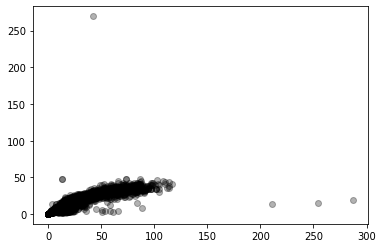

In [38]:
plt.scatter(TOT_DBH, TOT_H,  c='k', alpha=0.3, marker ='o', label='Observed')

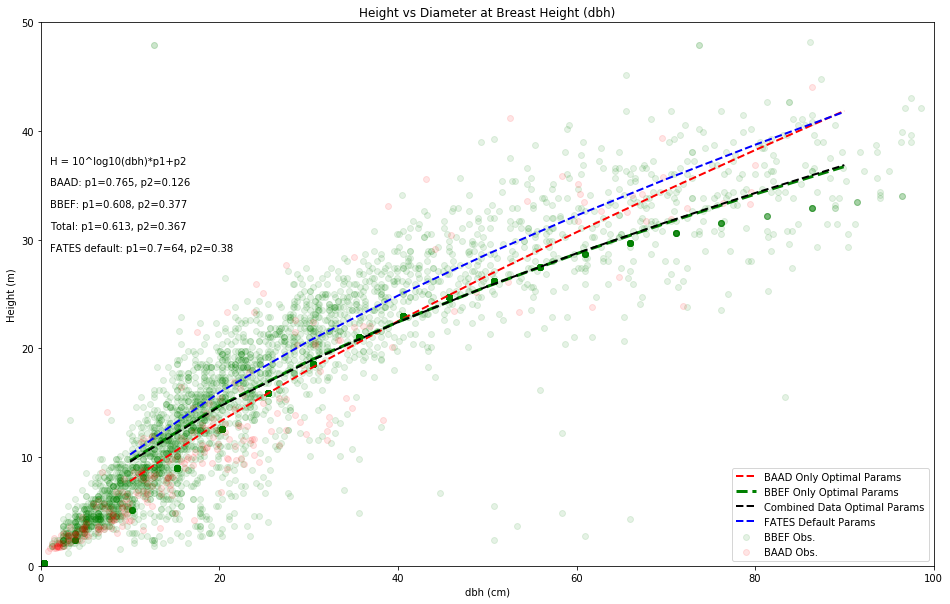

In [39]:
# Visually inspect the results from the curve fitting

fig = plt.figure(figsize = (16,10))

plt.scatter(BBEF_DBH, BBEF_H,  c='g', alpha=0.1, marker ='o', label='BBEF Obs.')
plt.scatter(BAAD_DBH, BAAD_H,  c='r', alpha=0.1, marker ='o', label='BAAD Obs.')
#plt.scatter(TOT_DBH, TOT_H,  c='k', alpha=0.1, marker ='o', label='TOT Obs.')
#plt.plot(dbh_mod,BAAD_Hobs, c='r', linewidth = 1.5, label='BAAD mean Height')
#plt.plot(dbh_mod,BBEF_Hobs, c='g', linewidth = 1.5, label='BBEF mean Height')
#plt.plot(dbh_mod,TOT_Hobs, c='k', linewidth = 1.5, label='Total mean Height')

plt.plot(dbh_mod, baad_hopt,'r--', linewidth=2, label ='BAAD Only Optimal Params')
plt.plot(dbh_mod, bbef_hopt,'g--', linewidth=3, label ='BBEF Only Optimal Params')
plt.plot(dbh_mod, tot_hopt, 'k--', linewidth=2, label ='Combined Data Optimal Params')
plt.plot(dbh_mod, hmod, 'b--', linewidth=2, label ='FATES Default Params')

plt.xlabel('dbh (cm)')
plt.ylabel('Height (m)')
plt.text(1,37, "H = 10^log10(dbh)*p1+p2")
plt.text(1,35, "BAAD: p1=0.765, p2=0.126")
plt.text(1,33, "BBEF: p1=0.608, p2=0.377")
plt.text(1,31, "Total: p1=0.613, p2=0.367")
plt.text(1,29, "FATES default: p1=0.7=64, p2=0.38")
plt.legend()
plt.title("Height vs Diameter at Breast Height (dbh)")
plt.xlim(0,100)
plt.ylim(0,50)
#plt.savefig(data_dir_out + 'd2h.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

In [33]:
# Model heights using the optimal parameters
hopt = [] # height with popt

for i in dbh_mod:
    test = d2h(i, popt[0], popt[1])
    hopt.append(test)

hopt

[7.779521002261802,
 13.22634816884168,
 18.041234739745235,
 22.486768251227932,
 26.676405777690697,
 30.672794892422882,
 34.515322310972266,
 38.230866141543316,
 41.83884211379585]

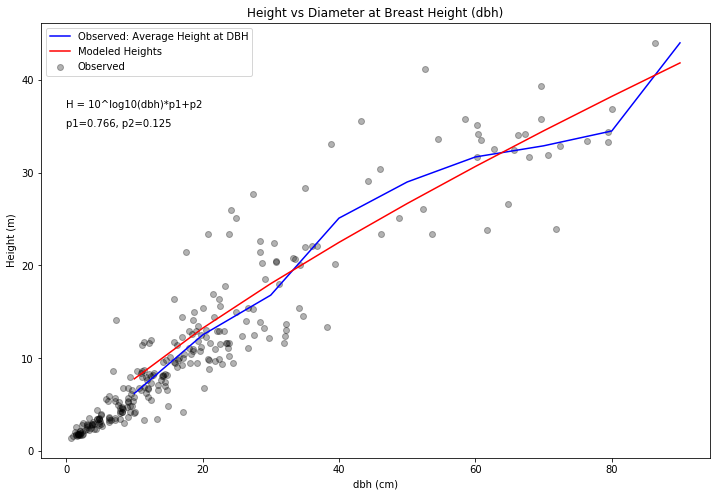

In [34]:
# Visually inspect the results from the curve fitting

fig = plt.figure(figsize = (12,8))

plt.scatter(DBH,H,  c='k', alpha=0.3, marker ='o', label='Observed')
plt.plot(dbh_mod,Hobs, c='b', label='Observed: Average Height at DBH')
plt.plot(dbh_mod, hopt, c='r', label ='Modeled Heights')
plt.xlabel('dbh (cm)')
plt.ylabel('Height (m)')
plt.text(0,37, "H = 10^log10(dbh)*p1+p2")
plt.text(0,35, "p1=0.766, p2=0.125")
plt.legend()
plt.title("Height vs Diameter at Breast Height (dbh)")
#plt.savefig(data_dir_out + 'd2h.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

In [35]:
# Model heights using ensemble generated parameters
hens1 = [] # height with popt, from params_wrftest_c200827v02.pondo.ens.8.v02

for i in dbh_mod:
#    test = d2h(i, popt[0], popt[1]) ## popt[0] = d2h1, popt[1] = d2h2
    test = d2h(i, 0.6313, 0.0016)
    hens1.append(test)

hens1

[4.294375337334885,
 6.6518161353590735,
 8.592244922107543,
 10.303397915395784,
 11.862050366859311,
 13.309044720646654,
 14.66933385482086,
 15.959552465478897,
 17.19148118228999]

In [36]:
# Model heights using ensemble generated parameters
hens2 = [] # height with popt, from params_wrftest_c200827v02.pondo.ens.6.v03 

for i in dbh_mod:
#    test = d2h(i, popt[0], popt[1]) ## popt[0] = d2h1, popt[1] = d2h2
    test = d2h(i, 1.0193, 0.0027)
    hens2.append(test)

hens2

[10.519618738232229,
 21.3225859932517,
 32.23514996133178,
 43.219501082034064,
 54.257543268799466,
 65.33856161134648,
 76.455447072828,
 87.60313005050679,
 98.77780924255872]

In [37]:
# Model heights using ensemble generated parameters
hens3 = [] # height with popt, from params_wrftest_c200827v02.pondo.ens.6.v03 

for i in dbh_mod:
#    test = d2h(i, popt[0], popt[1]) ## popt[0] = d2h1, popt[1] = d2h2
    test = d2h(i, 0.9, 0.1)
    hens3.append(test)

hens3

[10.0,
 18.660659830736158,
 26.87875379522287,
 34.822022531844965,
 42.56699612603924,
 50.15752812467622,
 57.62198777951312,
 64.98019170849885,
 72.24674055842078]

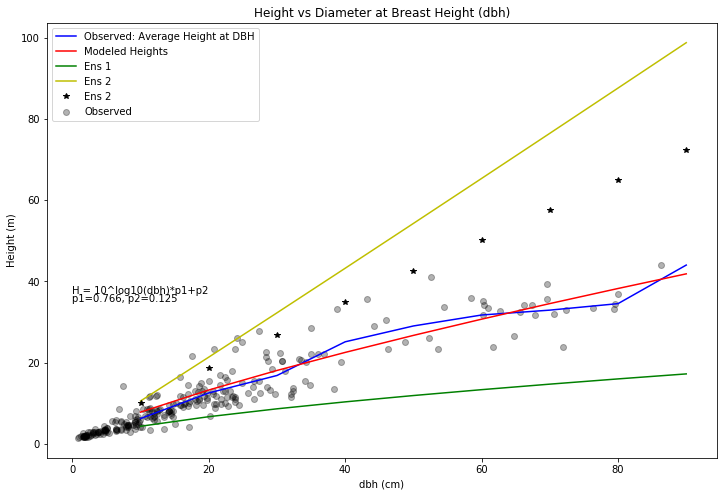

In [38]:
# Visually inspect the results from the curve fitting

fig = plt.figure(figsize = (12,8))

plt.scatter(DBH,H,  c='k', alpha=0.3, marker ='o', label='Observed')
plt.plot(dbh_mod,Hobs, c='b', label='Observed: Average Height at DBH')
plt.plot(dbh_mod, hopt, c='r', label ='Modeled Heights')
plt.plot(dbh_mod, hens1, c='g', label='Ens 1')
plt.plot(dbh_mod, hens2, c='y', label='Ens 2')
plt.plot(dbh_mod, hens3, 'k*', label='Ens 2')
plt.xlabel('dbh (cm)')
plt.ylabel('Height (m)')
plt.text(0,37, "H = 10^log10(dbh)*p1+p2")
plt.text(0,35, "p1=0.766, p2=0.125")
plt.legend()
plt.title("Height vs Diameter at Breast Height (dbh)")
#plt.savefig(data_dir_out + 'd2h.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

#### 2.2 Diameter to above ground biomass (d2bagw)
Here I will test the Chojnacky (2014), the Saldarriaga et al. (1998) and the FATES 2 parameter power functions.

In [39]:
# Define the Chojnacky diameter to above ground biomass function (d2bagw_choj) 
def d2bagw_choj(dbh,p1,p2):
    ln_agb = p1+(p2*np.log(dbh))
    agb_choj = np.exp(ln_agb)
    return agb_choj

# Define the Saldarriaga diameter to above ground biomass function (d2bagw_sal) 
# Need to fix this so that h changes with dbh
def d2bagw_sal(dbh,p1,p2,p3,p4):
    agb_sal = allom_frac * p1 * (h_sal_mod**p2) * (dbh**p3) * (rho**p4)
    return agb_sal

# Define the 2-parameter power function (d2bagw_pow)
def d2bagw_pow(dbh,p1,p2):
    agb_pow = (p1*np.power(dbh,p2))/c2b
    return agb_pow

In [40]:
# Define constants for the functions

# In d2bagw_sal
allom_frac = 0.6 
rho = 0.367 # Density of tree from USDA Survey of Tree Density, value for S. Idaho ponderosa pine
h_sal_mod = 29 # Observed height at dbh=50 from baad
# In d2bagw_pow
c2b = 2

In [41]:
# From Delucia (2000), in montane ponderosa pine at dbh=50, agb=945. We will use this as a guide.
# We need to create an objective/cost function. Use RMSE for now.

def RMSE_d2bagw(agb_mod):
    RMSE_d2bagw = np.sqrt(np.mean((agb_mod-agb_obs)**2)) 
    return RMSE_d2bagw

# For d2abagw we will calculate the 

In [42]:
# Test the functions at dbh=50 to find RMSE for observed agb at dbh 50.
dbh_bagw = 50
agb_obs=945

# Chojnacky with default parameters for pines with density < 0.45
agb_choj = d2bagw_choj(dbh_bagw,-2.6177,2.4638)

# Saldarriaga with default parameters
agb_sal = d2bagw_sal(dbh_bagw,0.284,0.57,1.94,1)

# 2-parameter with default parameters
agb_pow = d2bagw_pow(dbh_bagw,0.1,2.4)

print("agb_choj =", agb_choj, "agb_sal=",agb_sal,"agb_pow=",agb_pow)

agb_choj = 1119.6173798341167 agb_sal= 842.7607906352225 agb_pow= 597.720312368773


In [43]:
# Calculate the RMSE for each of the functions

RMSE_choj = RMSE_d2bagw(agb_choj)

RMSE_sal = RMSE_d2bagw(agb_sal)

RMSE_pow = RMSE_d2bagw(agb_pow)

print("choj RMSE=",RMSE_choj,", sal RMSE=",RMSE_sal,", power RMSE=",RMSE_pow)

choj RMSE= 174.61737983411672 , sal RMSE= 102.23920936477748 , power RMSE= 347.27968763122703


Well, they are all terrible.  How can I make them fit better?

In [44]:

# Use the d2bagw functions to model the heights at dbh from 10-90cm at 10cm intervals
# Chojnacky with default parameters for pines with density < 0.45
choj_mod = []

for i in dbh_mod:
    test_choj = d2bagw_choj(i, -2.6177, 2.4638)
    choj_mod.append(test_choj)

# Check the output. choj_mod will serve as the observed values for the curve fitting process.
choj_mod

[21.22986999644574,
 117.118375014528,
 318.03775715991225,
 646.1044635855067,
 1119.6173798341167,
 1754.5121716746257,
 2565.0739237402427,
 3564.3508357534165,
 4764.419894998952]

In [45]:
# Find the best fit params for the 2-param (d2bagw_pow)

agbpow_opt, agb_pow_cov = curve_fit(d2bagw_pow, dbh_mod, choj_mod) 

# Check the results
agbpow_opt

array([0.145941, 2.4638  ])

In [46]:
# Find the best fit params for the Saldarriaga functions (d2bagw_sal).

agb_sal_opt, agb_sal_cov = curve_fit(d2bagw_sal, dbh_mod, choj_mod) 

# Check the results
agb_sal_opt

array([0.13128296, 0.62642287, 2.4638    , 2.18060605])

In [47]:
# Saldarriaga with best fit parameters. Work on this later...won't use this function anyways (most likely)
# Need to make a nested loop so that the h with also change with dbh. May need to re define the function.

#sal_opt = []
#h_sal_mod = np.array(hmod, dtype=np.int)
#h_sal_mod = [int(x) for x in hmod]
# work on this later...won't use this function anyways (most likely)
#for i in dbh_mod:
#    for j in range(len(h_sal_mod)):
        #h_sal_mod = j
#        h_sal_mod = h_sal_mod[j]
#        sal_test_opt = d2bagw_sal(i,agb_sal_opt[0],agb_sal_opt[1],agb_sal_opt[2],agb_sal_opt[3])
#        sal_opt.append(sal_test_opt)

# Check the output
#sal_opt

In [48]:
# 2-parameter with best fit parameters
agb_pow_opt = []

for i in dbh_mod:
    agb_pow_opt_test = d2bagw_pow(i, agbpow_opt[0], agbpow_opt[1])
    agb_pow_opt.append(agb_pow_opt_test)
    
# Check the output
agb_pow_opt

[21.229869996445633,
 117.11837501452763,
 318.0377571599114,
 646.1044635855059,
 1119.617379834116,
 1754.5121716746246,
 2565.07392374024,
 3564.3508357534224,
 4764.419894998947]

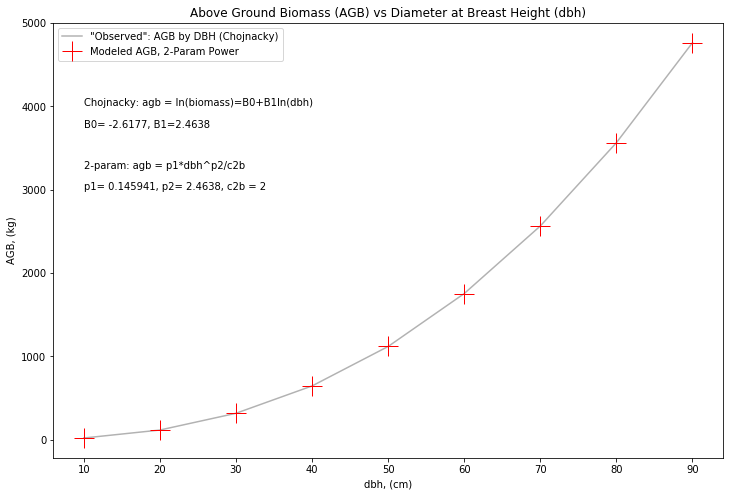

In [49]:
# Visually inspect the results from the curve fitting

fig = plt.figure(figsize = (12,8))

plt.plot(dbh_mod,choj_mod, c='k', alpha=0.3, label='"Observed": AGB by DBH (Chojnacky)')
plt.plot(dbh_mod, agb_pow_opt,'r+', markersize=20, label ='Modeled AGB, 2-Param Power')
#plt.plot(dbh_mod, sal_opt, 'bo', label ='Modeled AGB, Saldarriaga')
plt.xlabel('dbh, (cm)')
plt.ylabel('AGB, (kg)')
plt.legend()
plt.text(10,4010,"Chojnacky: agb = ln(biomass)=B0+B1ln(dbh)")
plt.text(10,3750,"B0= -2.6177, B1=2.4638")
plt.text(10,3250,"2-param: agb = p1*dbh^p2/c2b")
plt.text(10,3000,"p1= 0.145941, p2= 2.4638, c2b = 2")
plt.title("Above Ground Biomass (AGB) vs Diameter at Breast Height (dbh)")
#plt.savefig(data_dir_out + 'd2bagw.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

In [50]:
# 2-parameter with best fit parameters
agb_pow_ens1 = [] # params_wrftest_c200827v02.pondo.ens.8.v02

for i in dbh_mod:
    agb_pow_ens1_test = d2bagw_pow(i, 0.1033, 3.6095)
    agb_pow_ens1.append(agb_pow_ens1_test)
    
# Check the output
agb_pow_ens1

[210.16980721245005,
 2565.2996104505596,
 11085.096923702498,
 31311.64356412828,
 70065.23072947562,
 135302.94954039517,
 236021.5734516765,
 382184.9965177435,
 584667.1100747883]

In [51]:
# 2-parameter with best fit parameters
agb_pow_ens2 = [] # params_wrftest_c200827v02.pondo.ens.6.v03

for i in dbh_mod:
    agb_pow_ens2_test = d2bagw_pow(i, 0.097, 2.3019)
    agb_pow_ens2.append(agb_pow_ens2_test)
    
# Check the output
agb_pow_ens2

[9.719451088724657,
 47.92726932756637,
 121.87851522933363,
 236.33259987920673,
 395.0033615651187,
 600.9911847199431,
 856.9844010596231,
 1165.3720011446624,
 1528.3139283183566]

In [52]:
# 2-parameter with best fit parameters
agb_pow_ens3 = [] # jsut testing values...

for i in dbh_mod:
    agb_pow_ens3_test = d2bagw_pow(i, 0.1, 2.7)
    agb_pow_ens3.append(agb_pow_ens3_test)
    
# Check the output
agb_pow_ens3

[25.059361681363626,
 162.83621261476185,
 486.6283338808569,
 1058.1128312793105,
 1932.8093419436996,
 3162.120242636547,
 4794.404942239327,
 6875.637462575209,
 9449.847061019504]

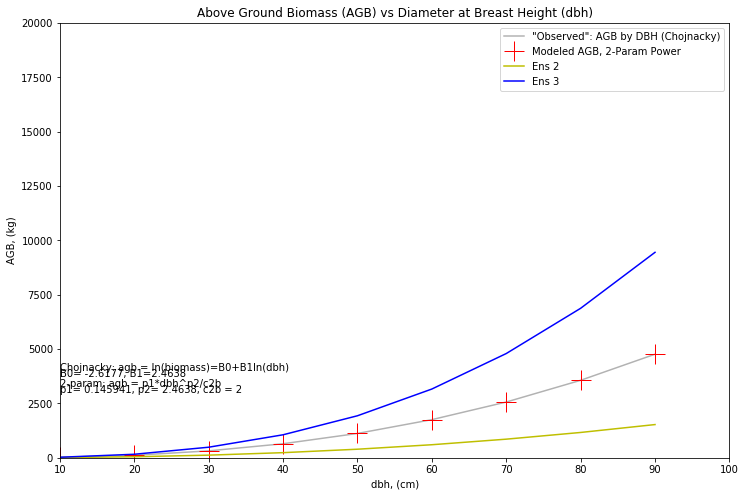

In [53]:
# Visually inspect the results from the curve fitting

fig = plt.figure(figsize = (12,8))

plt.plot(dbh_mod, choj_mod, c='k', alpha=0.3, label='"Observed": AGB by DBH (Chojnacky)')
plt.plot(dbh_mod, agb_pow_opt,'r+', markersize=20, label ='Modeled AGB, 2-Param Power')
#plt.plot(dbh_mod, agb_pow_ens1,'g*', markersize=20, label ='Ens 1')
plt.plot(dbh_mod, agb_pow_ens2,'y', markersize=20, label ='Ens 2')
plt.plot(dbh_mod, agb_pow_ens3, c='blue', markersize=20, label ='Ens 3')
plt.xlabel('dbh, (cm)')
plt.ylabel('AGB, (kg)')
plt.xlim(10,100)
plt.ylim(0, 20000)
plt.legend()
plt.text(10,4010,"Chojnacky: agb = ln(biomass)=B0+B1ln(dbh)")
plt.text(10,3750,"B0= -2.6177, B1=2.4638")
plt.text(10,3250,"2-param: agb = p1*dbh^p2/c2b")
plt.text(10,3000,"p1= 0.145941, p2= 2.4638, c2b = 2")
plt.title("Above Ground Biomass (AGB) vs Diameter at Breast Height (dbh)")
#plt.savefig(data_dir_out + 'd2bagw.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

#### 2.3 Diameter to leaf biomass (d2blmax)
Here I will use the 2-parameter power function from FATES, and the equation that Polly used in her Google sheet. 

In [54]:
# Define the 2-parameter power function (d2blmax)
def d2blmax_pow(dbh,p1,p2):
    blmax_pow = (p1*dbh**p2)/c2b
    return blmax_pow

# Define the function Polly used (d2blmax_polly)
def d2blmax_polly(dbh,p1,p2,p3): # remove dbh_max to test
    #if dbh<dbh_max:
    #    blmax_polly = p1*dbh**p2*rho**p3
    #else:
    #    blmax_polly = p1*dbh_max**p2*rho**p3
    blmax_polly = p1*dbh**p2*rho**p3  
    return blmax_polly
    

In [55]:
# Test the functions with the random parameters, dbh=50
print("blmax_pow",d2blmax_pow(50,0.065,1.8),"blmax_polly",d2blmax_polly(50,0.115,1.64,0.6))

blmax_pow 37.15603546909527 blmax_polly 38.530823051536906


In [56]:
# Since we have data from baad, use the curve_fit tool to fit the 2-parameter power function.

popt_bl_pow, pcov_blmax_pow = curve_fit(d2blmax_pow, dbh_mod, BLobs) 

# Check the results
popt_bl_pow

array([0.0035437 , 2.59195465])

In [57]:
# Since we have data from baad, use the curve_fit tool to fit the function Polly used.
popt_bl_polly, pcov_bl_polly = curve_fit(d2blmax_polly, dbh_mod, BLobs) 

# Check the results
popt_bl_polly

array([0.0169186 , 2.59195304, 2.25099953])

In [58]:
# Calculate the modeled heights with the optimal parameters.
blopt_pow = [] # height with popt

for i in dbh_mod:
    test = d2blmax_pow(i,popt_bl_pow[0],popt_bl_pow[1]) # Use params test code block
    blopt_pow.append(test)

blopt_pow

[0.6924387373696753,
 4.174817103963221,
 11.941476066090726,
 25.17059908830448,
 44.882796815476546,
 71.99695198546858,
 107.35867769516366,
 151.7573207848331,
 205.93713629988284]

In [59]:
# Calculate the modeled heights with the optimal parameters.
blopt_polly = [] # height with popt

for i in dbh_mod:
    test = d2blmax_polly(i,popt_bl_polly[0],popt_bl_polly[1],popt_bl_polly[2]) # Use params from the test code block.
    blopt_polly.append(test)

blopt_polly

[0.6924381559849097,
 4.174808935206183,
 11.941444897536185,
 25.17052172072565,
 44.88264271762348,
 71.9966836411493,
 107.35825088148496,
 151.75668480316497,
 205.9362341725152]

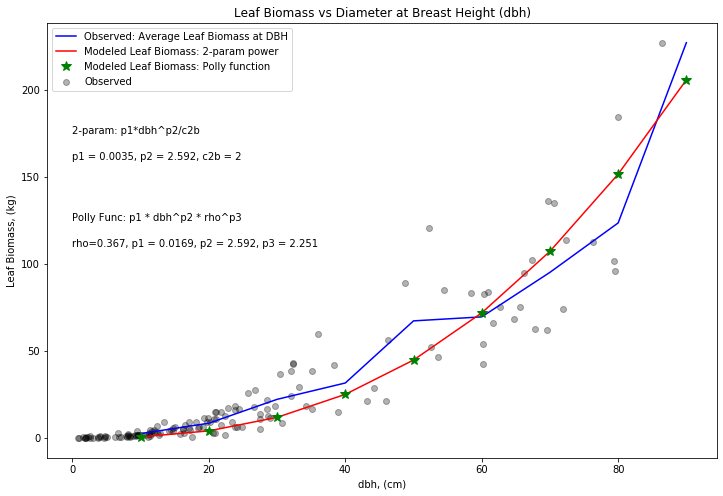

In [60]:
# Visually inspect the modeled outputs.

fig = plt.figure(figsize = (12,8))

plt.scatter(DBH,BL,  c='k', alpha=0.3, marker ='o', label='Observed')
plt.plot(dbh_mod,BLobs, c='b', label='Observed: Average Leaf Biomass at DBH')
plt.plot(dbh_mod, blopt_pow, c='r', label ='Modeled Leaf Biomass: 2-param power')
plt.plot(dbh_mod, blopt_polly, 'g*', markersize=10, label ='Modeled Leaf Biomass: Polly function')
plt.xlabel('dbh, (cm)')
plt.ylabel('Leaf Biomass, (kg)')
plt.text(0,175,"2-param: p1*dbh^p2/c2b")
plt.text(0,160, "p1 = 0.0035, p2 = 2.592, c2b = 2")
plt.text(0,125, "Polly Func: p1 * dbh^p2 * rho^p3")
plt.text(0,110, "rho=0.367, p1 = 0.0169, p2 = 2.592, p3 = 2.251" )
plt.title("Leaf Biomass vs Diameter at Breast Height (dbh)")
plt.legend()
#plt.savefig(data_dir_out + 'd2blmax.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

In [61]:
# Calculate the modeled heights with the optimal parameters.
rho = 0.367

blopt_ens1 = [] # params_wrftest_c200827v02.pondo.ens.8.v02

for i in dbh_mod:
    test = d2blmax_polly(i, 0.2018, 1.3558, 0.9054) 
    blopt_ens1.append(test)

blopt_ens1

[1.8474377621296252,
 4.728313727185427,
 8.19314825755516,
 12.101598852736604,
 16.376962265262282,
 20.96946168860722,
 25.843643356557017,
 30.972711042955854,
 36.33555605840711]

In [66]:
# Calculate the modeled heights with other parameters.
rho = 0.2796

blopt_ens2 = [] # params_wrftest_c200827v02.pondo.ens.6.v03

for i in dbh_mod:
    test = d2blmax_polly(i, 0.1274, 2.1487, 0.6381) # Use params from the test code block.
    blopt_ens2.append(test)

blopt_ens2

[7.956183559548308,
 35.27994878387736,
 84.31313430702711,
 156.4411852588872,
 252.6862688110492,
 373.8680785701937,
 520.675272372608,
 693.7040808967902,
 893.4817256878839]

In [67]:
# Calculate the modeled heights with other parameters.
rho = 0.367

blopt_ens3 = [] # testing values...

for i in dbh_mod:
    test = d2blmax_polly(i, 0.03, 2.5, 2.0) # Use params from the test code block.
    blopt_ens3.append(test)

blopt_ens3

[1.2777720473112566,
 7.22817023571526,
 19.918494957909598,
 40.88870551396021,
 71.42962893842619,
 112.67602284614344,
 165.65268640135673,
 231.30144754288833,
 310.4986074966353]

In [89]:
# Calculate the modeled heights with other parameters.
rho = 0.367

blopt_ens4 = [] # testing values...

for i in dbh_mod:
    test = d2blmax_polly(i, 0.15, 3, 2) # Use params from the test code block.
    blopt_ens4.append(test)

blopt_ens4

[20.20335,
 161.6268,
 545.49045,
 1293.0144,
 2525.4187500000003,
 4363.9236,
 6929.74905,
 10344.1152,
 14728.24215]

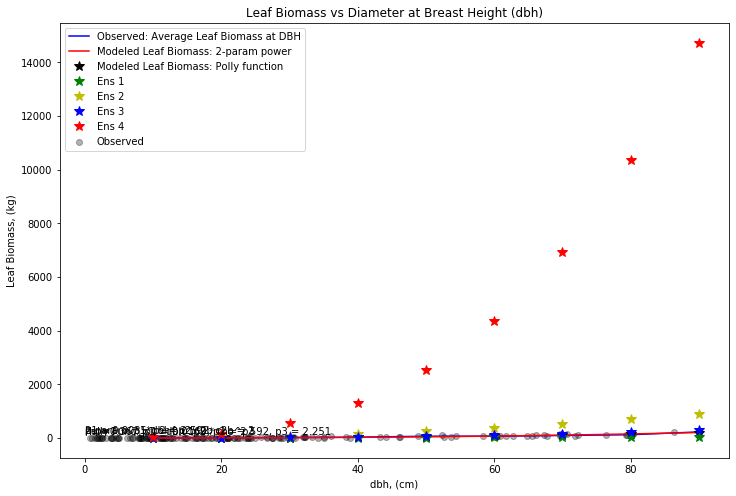

In [90]:
# Visually inspect the modeled outputs.

fig = plt.figure(figsize = (12,8))

plt.scatter(DBH,BL,  c='k', alpha=0.3, marker ='o', label='Observed')
plt.plot(dbh_mod,BLobs, c='b', label='Observed: Average Leaf Biomass at DBH')
plt.plot(dbh_mod, blopt_pow, c='r', label ='Modeled Leaf Biomass: 2-param power')
plt.plot(dbh_mod, blopt_polly, 'k*', markersize=10, label ='Modeled Leaf Biomass: Polly function')
plt.plot(dbh_mod, blopt_ens1, 'g*', markersize=10, label ='Ens 1')
plt.plot(dbh_mod, blopt_ens2, 'y*', markersize=10, label ='Ens 2')
plt.plot(dbh_mod, blopt_ens3, 'b*', markersize=10, label ='Ens 3')
plt.plot(dbh_mod, blopt_ens4, 'r*', markersize=10, label ='Ens 4')
plt.xlabel('dbh, (cm)')
plt.ylabel('Leaf Biomass, (kg)')
plt.text(0,175,"2-param: p1*dbh^p2/c2b")
plt.text(0,160, "p1 = 0.0035, p2 = 2.592, c2b = 2")
plt.text(0,125, "Polly Func: p1 * dbh^p2 * rho^p3")
plt.text(0,110, "rho=0.367, p1 = 0.0169, p2 = 2.592, p3 = 2.251" )
plt.title("Leaf Biomass vs Diameter at Breast Height (dbh)")
plt.legend()
#plt.savefig(data_dir_out + 'd2blmax.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

In [67]:
# Want to see the observed BLMAX for the range of dbh.
pipo_stats_blmax = []

for i in dbh_mod:
    mask =  (pipo['d.bh']>= ((i/100) - 0.05)) & (pipo['d.bh']<((i/100) + 0.05))
    pipo_ = pipo.loc[mask].copy()
    stats = pipo_['m.lf'].describe()
    #stats = pd.DataFrame(stats)
    pipo_stats_blmax.append(stats)

In [90]:
#pipo_stats_blmax

#### 2.4 Leaf Area (or diameter?) to Sapwood (d2bsap)
Here I will use a liner function and baad data to determine the two parameters: fates_allom_la_per_sa_int and fates_allom_la_per_sa_slp

In [112]:
# Set the variables from baad for leaf area ('a.lf') and
# sapwood area at breast height ('a.ssbh')
LF = pipo['a.lf'].values # units = m2
#LF = pd.isna(pipo['a.lf'])
SAP = pipo['a.ssbh'].values # units = m2
#SAP = pd.isna(pipo['a.ssbh'])

# Test dropping the nans
LF_nan = pipo['a.lf'].fillna(0).values
SAP_nan = pipo['a.ssbh'].fillna(0).values

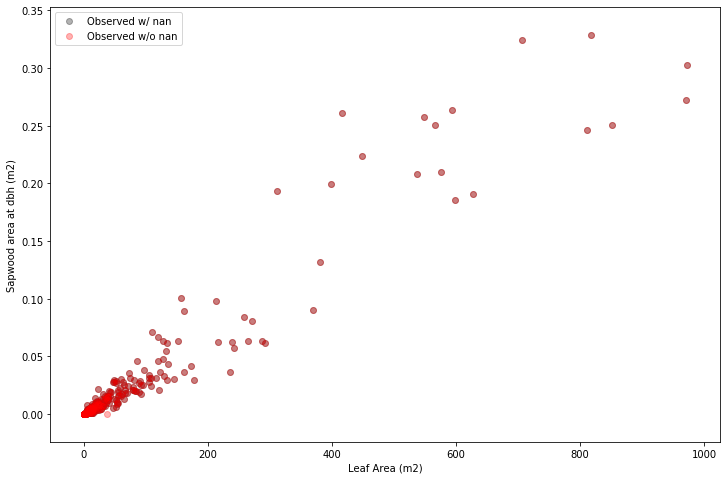

In [105]:
fig = plt.figure(figsize = (12,8))

plt.scatter(LF,SAP,  c='k', alpha=0.3, marker ='o', label='Observed w/ nan')
plt.scatter(LF_nan, SAP_nan, c='r', alpha=0.3, marker='o', label = 'Observed w/o nan')
plt.xlabel('Leaf Area (m2)')
plt.ylabel('Sapwood area at dbh (m2)')
#plt.xticks(rotation=90)
plt.legend()
# extra plot specifics: title, x and y axis labels, etc.
plt.show()

In [106]:
# Import the polyfit function
from numpy.polynomial.polynomial import polyfit

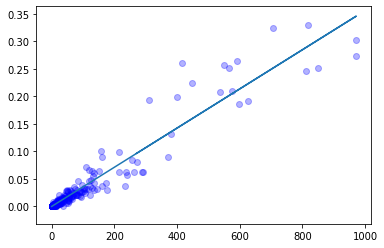

In [107]:
# Fit with polyfit
b,m = polyfit(LF_nan, SAP_nan,1)

plt.scatter(LF_nan, SAP_nan, c='b', alpha=0.3, marker='o', label = 'Observed (badd)')
plt.plot(LF_nan, b+m * LF_nan, '-')
plt.show()

In [108]:
print("slope =", m," intercept =", b)

slope = 0.0003561237275241073  intercept = -0.00015616175961951455


I think this is more of a log-linear model like the d2h.

In [109]:
def lf2sap(leafmod,p1,p2):
    sapmod = 10**((np.log10(leafmod))*p1+p2)
    return sapmod

In [110]:
lf_mod = [100,200,300,400,500,600,700,800,900,1000]
sap_mod = []

for i in lf_mod:
    test_sap = lf2sap(i, 0.7, 0.2)
    sap_mod.append(test_sap)

# Check the output
sap_mod

[39.81071705534971,
 64.67270065773575,
 85.89836120408869,
 105.06111217615067,
 122.82280261157895,
 139.54229946218894,
 155.44209038050334,
 170.67228025785937,
 185.3402551702235,
 199.52623149688787]

In [127]:
SAP_obs = [sap_pipo_10['a.ssbh'].mean(),sap_pipo_20['a.ssbh'].mean(),
           sap_pipo_30['a.ssbh'].mean(),sap_pipo_40['a.ssbh'].mean(),
           sap_pipo_50['a.ssbh'].mean(),sap_pipo_60['a.ssbh'].mean(),
           sap_pipo_70['a.ssbh'].mean(),sap_pipo_80['a.ssbh'].mean(),
           sap_pipo_90['a.ssbh'].mean(),sap_pipo_100['a.ssbh'].mean()]

# Use the curve fit to find the best params. Need to make a SAP_obs
sapopt, sapcov = curve_fit(lf2sap, lf_mod, SAP_obs) 

# Check the results
sapopt

array([ 0.75500844, -2.75687041])

In [128]:
# Model heights using the optimal parameters
sapopt = [] # sap with sapopt

for i in lf_mod:
    test_sap = lf2sap(i, 0.755, -2.757)
    sapopt.append(test_sap)

sapopt

[0.05662392890382532,
 0.09556033129598178,
 0.12978561138931402,
 0.16127063406193423,
 0.19086326696277692,
 0.21903029800139015,
 0.2460645329402,
 0.2721654169467278,
 0.2974767955842091,
 0.32210687912834346]

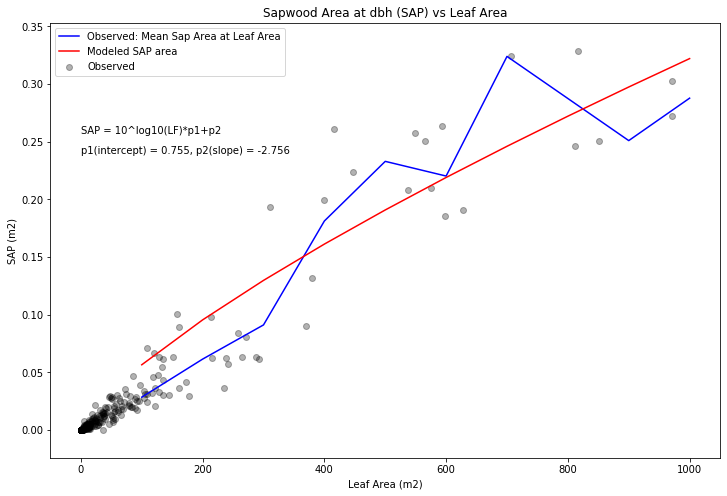

In [148]:
# Visually inspect the results from the curve fitting

fig = plt.figure(figsize = (12,8))

plt.scatter(LF_nan,SAP_nan,  c='k', alpha=0.3, marker ='o', label='Observed')
plt.plot(lf_mod,SAP_obs, c='b', label='Observed: Mean Sap Area at Leaf Area')
plt.plot(lf_mod, sapopt, c='r', label ='Modeled SAP area')
plt.xlabel('Leaf Area (m2)')
plt.ylabel('SAP (m2)')
#plt.xticks(rotation=90)
plt.legend()
plt.text(0,0.257,"SAP = 10^log10(LF)*p1+p2")
plt.text(0,0.24,"p1(intercept) = 0.755, p2(slope) = -2.756")
plt.title("Sapwood Area at dbh (SAP) vs Leaf Area")
#plt.savefig(data_dir_out + 'lf2sap.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

In [133]:
# Model heights using the ensemble generated parameters
sap_ens1 = [] # params_wrftest_c200827v02.pondo.ens.8.v02

for i in lf_mod:
    test_sap = lf2sap(i, 0.4403, -2)
    sap_ens1.append(test_sap)

sap_ens1

[0.07596263129545539,
 0.10307266546964934,
 0.12321866196113047,
 0.13985790362759384,
 0.1542966485416802,
 0.16719373338370958,
 0.17893556420292045,
 0.1897712950177369,
 0.1998724688253351,
 0.20936303241480966]

In [136]:
# Model heights using the ensemble generated parameters
sap_ens2 = [] # params_wrftest_c200827v02.pondo.ens.6.v03

for i in lf_mod:
    test_sap = lf2sap(i, 0.3672, 0)
    sap_ens2.append(test_sap)

sap_ens2

[0.05425003216311501,
 0.06997424389544805,
 0.08120802056232891,
 0.09025607199674139,
 0.09796293440153259,
 0.10474592567999454,
 0.11084599350553462,
 0.11641652812215512,
 0.12156200357306778,
 0.12635720185226545]

In [140]:
# With regular linear fit...

def lf2sap_lin(leafmod,p1,p2):
    saplinmod = (p1 * leafmod)  + p2 
    return saplinmod

In [141]:
sap_lin = []

for i in lf_mod:
    test_sap = lf2sap_lin(i,0.0003, -0.0001 )
    sap_lin.append(test_sap)
    
sap_lin

[0.0299,
 0.059899999999999995,
 0.0899,
 0.11989999999999999,
 0.1499,
 0.1799,
 0.2099,
 0.2399,
 0.2699,
 0.2999]

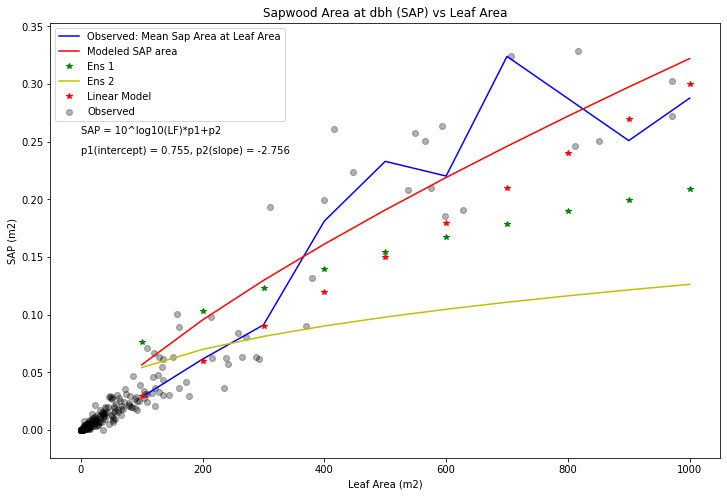

In [149]:
# Visually inspect the results from the curve fitting

fig = plt.figure(figsize = (12,8))

plt.scatter(LF_nan,SAP_nan,  c='k', alpha=0.3, marker ='o', label='Observed')
plt.plot(lf_mod,SAP_obs, c='b', label='Observed: Mean Sap Area at Leaf Area')
plt.plot(lf_mod, sapopt, c='r', label ='Modeled SAP area')
plt.plot(lf_mod, sap_ens1, 'g*', label='Ens 1')
plt.plot(lf_mod, sap_ens2, 'y-', label='Ens 2')
plt.plot(lf_mod, sap_lin, 'r*', label='Linear Model')
plt.xlabel('Leaf Area (m2)')
plt.ylabel('SAP (m2)')
#plt.xticks(rotation=90)
plt.legend()
plt.text(0,0.257,"SAP = 10^log10(LF)*p1+p2")
plt.text(0,0.24,"p1(intercept) = 0.755, p2(slope) = -2.756")
plt.title("Sapwood Area at dbh (SAP) vs Leaf Area")
#plt.savefig(data_dir_out + 'lf2sap.png', edgecolor='black', bbox_inches='tight', pad_inches=0.25)
plt.show()

In [117]:
sap_mask10 = (pipo['a.lf'] >= 50) & (pipo['a.lf'] < 150)
sap_pipo_10 = pipo.loc[sap_mask10].copy()
sap_pipo_10['a.ssbh'].mean()

0.028520599022982467

In [118]:
sap_mask20 = (pipo['a.lf'] >= 150) & (pipo['a.lf'] < 250)
sap_pipo_20 = pipo.loc[sap_mask20].copy()
sap_pipo_20['a.ssbh'].mean()

0.06153684422363637

In [119]:
sap_mask30 = (pipo['a.lf'] >= 250) & (pipo['a.lf'] < 350)
sap_pipo_30 = pipo.loc[sap_mask30].copy()
sap_pipo_30['a.ssbh'].mean()

0.09118494571833334

In [120]:
sap_mask40 = (pipo['a.lf'] >= 350) & (pipo['a.lf'] < 450)
sap_pipo_40 = pipo.loc[sap_mask40].copy()
sap_pipo_40['a.ssbh'].mean()

0.1812905004

In [121]:
sap_mask50 = (pipo['a.lf'] >= 450) & (pipo['a.lf'] < 550)
sap_pipo_50 = pipo.loc[sap_mask50].copy()
sap_pipo_50['a.ssbh'].mean()

0.23299999999999998

In [122]:
sap_mask60 = (pipo['a.lf'] >= 550) & (pipo['a.lf'] < 650)
sap_pipo_60 = pipo.loc[sap_mask60].copy()
sap_pipo_60['a.ssbh'].mean()

0.2202630962

In [123]:
sap_mask70 = (pipo['a.lf'] >= 650) & (pipo['a.lf'] < 750)
sap_pipo_70 = pipo.loc[sap_mask70].copy()
sap_pipo_70['a.ssbh'].mean()

0.324

In [124]:
sap_mask80 = (pipo['a.lf'] >= 750) & (pipo['a.lf'] < 850)
sap_pipo_80 = pipo.loc[sap_mask80].copy()
sap_pipo_80['a.ssbh'].mean()

0.2875

In [125]:
sap_mask90 = (pipo['a.lf'] >= 850) & (pipo['a.lf'] < 950)
sap_pipo_90 = pipo.loc[sap_mask90].copy()
sap_pipo_90['a.ssbh'].mean()

0.251

In [126]:
sap_mask100 = (pipo['a.lf'] >= 950) & (pipo['a.lf'] < 1050)
sap_pipo_100 = pipo.loc[sap_mask100].copy()
sap_pipo_100['a.ssbh'].mean()

0.2878062435